<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%92%D0%B0%D1%80%D1%8C%D0%B8%D1%80%D1%83%D0%B5%D0%BC_%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%8B_%D0%BF%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Варьируем параметры портфеля

Проект "Оптимизация инвестиционного портфеля".

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург - 2020

15.09.2020

Варьируем параметры (глубина обучения и теста). Смотрим коэффициент Шарпа. Выявляем вид зависимости.

# Подгружаем библиотеки

In [1]:
!pip install bt

     |████████████████████████████████| 2.7MB 4.6MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533288 sha256=f51534e7b43ad27132db83793a13b2bc182ed54d555640492fdfe2281f6acd4b
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=bd991ce2f11078e6c6bfd515a37d7a5c82eda01b71d8f81583861c4a4cbed565
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn


In [17]:
import bt
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Подгружаем историю котировок

In [4]:
# fetch some data
data = bt.get(['AAPL','GE','BAC','AMD','PLUG','F'], start='2010-01-01')
print( data.head())

                aapl         ge        bac   amd  plug         f
Date                                                            
2010-01-04  6.604801  10.858186  13.816905  9.70   7.0  6.937616
2010-01-05  6.616219  10.914412  14.266021  9.71   7.0  7.396526
2010-01-06  6.510980  10.858186  14.433337  9.57   6.7  7.673220
2010-01-07  6.498945  11.420421  14.908874  9.47   6.7  7.868933
2010-01-08  6.542150  11.666402  14.776777  9.43   6.8  7.889179


# Равновесная стратегия

## Считаем

In [5]:
s0 = bt.Strategy('равномерный', [bt.algos.RunMonthly(),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)
res0 = bt.run(test0)



равномерный
0% [############################# ] 100% | ETA: 00:00:00

## График истории баланса

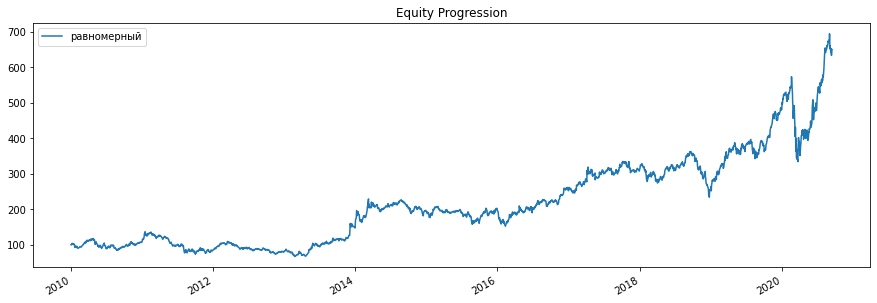

In [6]:
res0.plot()

## График истории долей портфеля

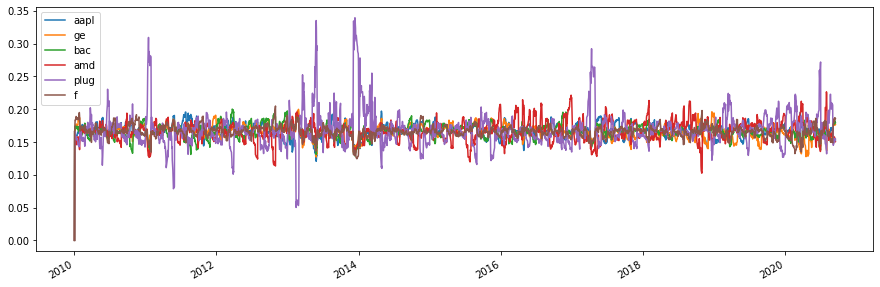

In [7]:
res0.plot_security_weights()

## Итоги по всему портфелю

In [8]:
res0.display()

Stat                 равномерный
-------------------  -------------
Start                2010-01-03
End                  2020-09-14
Risk-free rate       0.00%

Total Return         550.02%
Daily Sharpe         0.73
Daily Sortino        1.21
CAGR                 19.12%
Max Drawdown         -50.61%
Calmar Ratio         0.38

MTD                  -4.14%
3m                   38.54%
6m                   62.65%
YTD                  34.37%
1Y                   66.70%
3Y (ann.)            28.42%
5Y (ann.)            31.32%
10Y (ann.)           21.61%
Since Incep. (ann.)  19.12%

Daily Sharpe         0.73
Daily Sortino        1.21
Daily Mean (ann.)    22.18%
Daily Vol (ann.)     30.54%
Daily Skew           0.10
Daily Kurt           7.06
Best Day             14.06%
Worst Day            -13.99%

Monthly Sharpe       0.77
Monthly Sortino      1.64
Monthly Mean (ann.)  22.52%
Monthly Vol (ann.)   29.33%
Monthly Skew         0.52
Monthly Kurt         1.20
Best Month           35.84%
Worst Month     

# Стратегия с оптимизацией

## Объявляем сетку параметров

In [56]:
lookbackList = list(range(20,400,10))
print(lookbackList)

[20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390]


In [58]:
testlenList = list(range(20,300,10))
print(testlenList)

[20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290]


In [59]:
dsArray = np.zeros([len(lookbackList),len(testlenList)])
dsArray.shape

(38, 28)

## Считаем по сетке

In [60]:
for indLB in range(len(lookbackList)):
    lookback = lookbackList[indLB]
    for indTL in range(len(testlenList)):
        testlen = testlenList[indTL]
        
        # с оптимизацией по наибольшему коэффициенту Шарпа (64 предыдущих дня на расчет, 64 дня на тестирование)

        s1 = bt.Strategy('оптимальный', [bt.algos.RunEveryNPeriods(testlen,offset=lookback),
                                         bt.algos.SelectAll(),
                                         bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=lookback)),
                                         bt.algos.Rebalance()])
        test1 = bt.Backtest(s1, data, progress_bar=False)
        res1 = bt.run(test1)

        dsArray[indLB,indTL] = res1[0].daily_sharpe
        print('Глубины: обучения = ' + str(lookback) + ', тестирования = ' + str(testlen) + '; коэф-т Шарпа %1.2f' % res1[0].daily_sharpe)


Глубины: обучения = 20, тестирования = 20; коэф-т Шарпа 0.49
Глубины: обучения = 20, тестирования = 30; коэф-т Шарпа 0.59
Глубины: обучения = 20, тестирования = 40; коэф-т Шарпа 0.55
Глубины: обучения = 20, тестирования = 50; коэф-т Шарпа 0.66
Глубины: обучения = 20, тестирования = 60; коэф-т Шарпа 0.83
Глубины: обучения = 20, тестирования = 70; коэф-т Шарпа 0.67
Глубины: обучения = 20, тестирования = 80; коэф-т Шарпа 0.75
Глубины: обучения = 20, тестирования = 90; коэф-т Шарпа 0.66
Глубины: обучения = 20, тестирования = 100; коэф-т Шарпа 0.67
Глубины: обучения = 20, тестирования = 110; коэф-т Шарпа 0.89
Глубины: обучения = 20, тестирования = 120; коэф-т Шарпа 0.77
Глубины: обучения = 20, тестирования = 130; коэф-т Шарпа 0.92
Глубины: обучения = 20, тестирования = 140; коэф-т Шарпа 0.67
Глубины: обучения = 20, тестирования = 150; коэф-т Шарпа 0.82
Глубины: обучения = 20, тестирования = 160; коэф-т Шарпа 1.05
Глубины: обучения = 20, тестирования = 170; коэф-т Шарпа 0.95
Глубины: обучени

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Глубины: обучения = 30, тестирования = 70; коэф-т Шарпа 0.84
Глубины: обучения = 30, тестирования = 80; коэф-т Шарпа 0.78
Глубины: обучения = 30, тестирования = 90; коэф-т Шарпа 0.72
Глубины: обучения = 30, тестирования = 100; коэф-т Шарпа 0.96
Глубины: обучения = 30, тестирования = 110; коэф-т Шарпа 0.94
Глубины: обучения = 30, тестирования = 120; коэф-т Шарпа 0.99
Глубины: обучения = 30, тестирования = 130; коэф-т Шарпа 1.17
Глубины: обучения = 30, тестирования = 140; коэф-т Шарпа 1.03
Глубины: обучения = 30, тестирования = 150; коэф-т Шарпа 0.84
Глубины: обучения = 30, тестирования = 160; коэф-т Шарпа 1.01
Глубины: обучения = 30, тестирования = 170; коэф-т Шарпа 0.69
Глубины: обучения = 30, тестирования = 180; коэф-т Шарпа 0.96
Глубины: обучения = 30, тестирования = 190; коэф-т Шарпа 0.56
Глубины: обучения = 30, тестирования = 200; коэф-т Шарпа 0.84
Глубины: обучения = 30, тестирования = 210; коэф-т Шарпа 1.07
Глубины: обучения = 30, тестирования = 220; коэф-т Шарпа 0.46
Глубины: об

## Выводим результат на график

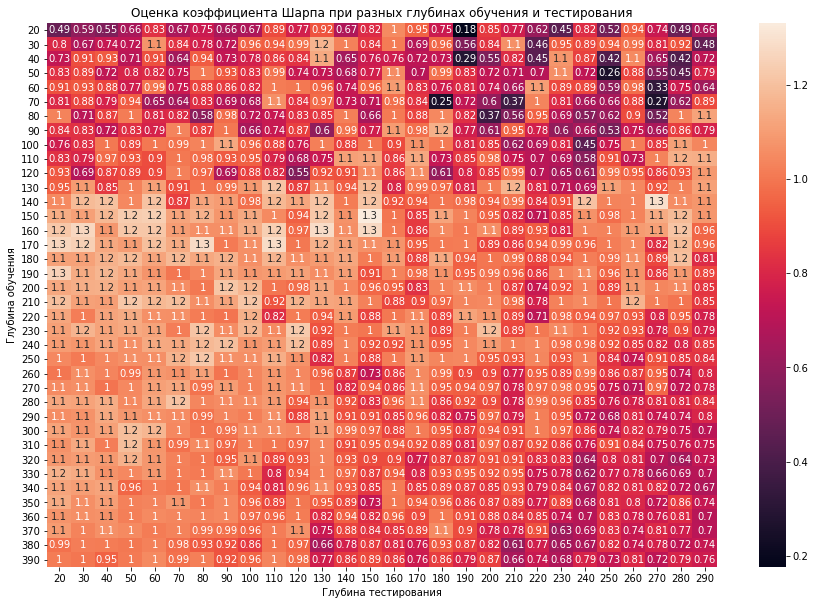

In [63]:
plt.figure(figsize=(15,10))
seaborn.heatmap(dsArray,xticklabels=testlenList,yticklabels=lookbackList,annot=True,fmt='.2g')
plt.xlabel('Глубина тестирования')
plt.ylabel('Глубина обучения')
plt.title('Оценка коэффициента Шарпа при разных глубинах обучения и тестирования')
plt.show()

Качество растет при увеличении глубины обучения до 150. Далее падает.
Тестирование лучше выбирать до 150 дней. 
Лучшие значения состредоточены на отрезке при глубине обучения в 150 и глубине тестирования до 150 дней.

# Лучшая модель

Лучшие результаты сосредоточились вокруг глубины обучения в 150 дней и глубины тестирования в 150 дней.

## Расчет

In [64]:
lookback_best = 150
testlen_best = 150

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(testlen_best,offset=lookback_best),
                                bt.algos.SelectAll(),
                                bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=lookback_best)),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)
res_best = bt.run(test_best)

лучший
0% [############################# ] 100% | ETA: 00:00:00

## График истории баланса

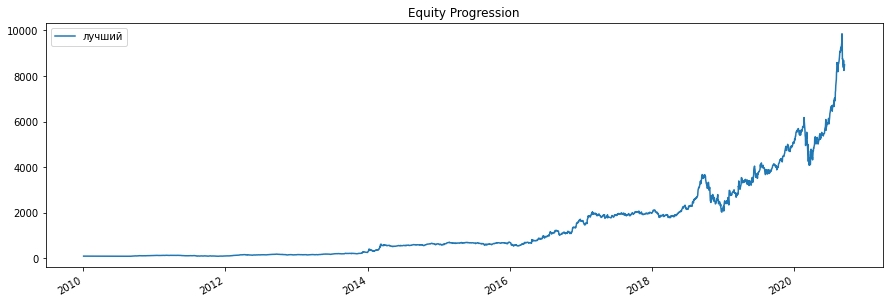

In [66]:
res_best.plot()

## График истории долей портфеля

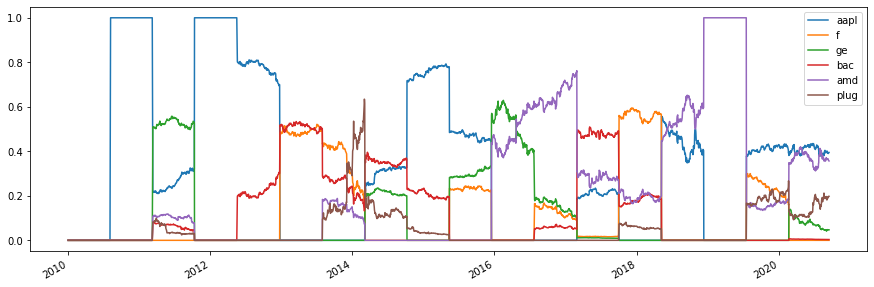

In [67]:
res_best.plot_security_weights()

## Итоги по всему портфелю

In [68]:
res_best.display()

Stat                 лучший
-------------------  ----------
Start                2010-01-03
End                  2020-09-14
Risk-free rate       0.00%

Total Return         8388.56%
Daily Sharpe         1.33
Daily Sortino        2.40
CAGR                 51.47%
Max Drawdown         -44.85%
Calmar Ratio         1.15

MTD                  -10.66%
3m                   48.15%
6m                   79.91%
YTD                  66.44%
1Y                   107.11%
3Y (ann.)            64.15%
5Y (ann.)            68.49%
10Y (ann.)           55.53%
Since Incep. (ann.)  51.47%

Daily Sharpe         1.33
Daily Sortino        2.40
Daily Mean (ann.)    47.99%
Daily Vol (ann.)     36.05%
Daily Skew           1.16
Daily Kurt           13.11
Best Day             22.53%
Worst Day            -14.06%

Monthly Sharpe       1.40
Monthly Sortino      3.79
Monthly Mean (ann.)  47.71%
Monthly Vol (ann.)   34.03%
Monthly Skew         0.81
Monthly Kurt         1.90
Best Month           39.79%
Worst Month         

# Выводы

Зависимость качества от глубины обучения и тестирования выявлена.

Окрестность лучших значений обозначена. 

Равновесная модель дает коэффициент = 0,7. Доходность в районе 22% годовых. Риск 38% годовых.

Лучшая модель дает дает коэффициент = 1,33. Доходность на уровне 61% годовых. Риск 55% годовых.

В следующих экспериментах можно путем оптимизации вычислять лучшие параметры.